# US Bike Share Activity Snapshot

> *It is prohibited to use this original work (e.g., code, language, formulas, etc.) in your assignments, projects, or assessments, as it will be a violation of Udacity Honor Code & Code of Conduct.*

<a id='intro'></a>
## Introduction

> **Tip**: Quoted sections like this will provide helpful instructions on how to navigate and use a Jupyter notebook.

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, you will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. You will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. You will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. **However, you do not need to download the data yourself.** The data has already been collected for you in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed for you. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

**Question 2**: However, there is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze. Run the first code cell below to load some packages and functions that you'll be using in your analysis. Then, complete the second code cell to print out the first trip recorded from each of the cities (the second line of each data file).

> **Tip**: You can run a code cell like you formatted Markdown cells above by clicking on the cell and using the keyboard shortcut **Shift** + **Enter** or **Shift** + **Return**. Alternatively, a code cell can be executed using the **Play** button in the toolbar after selecting it. While the cell is running, you will see an asterisk in the message to the left of the cell, i.e. `In [*]:`. The asterisk will change into a number to show that execution has completed, e.g. `In [1]`. If there is output, it will show up as `Out [1]:`, with an appropriate number to match the "In" number.

In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## TODO: Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = csv.DictReader(f_in)
        
        ## TODO: Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = next(trip_reader)
        
        ## TODO: Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

If everything has been filled out correctly, you should see below the printout of each city name (which has been parsed from the data file name) that the first trip has been parsed in the form of a dictionary. When you set up a `DictReader` object, the first row of the data file is normally interpreted as column names. Every other row in the data file will use those column names as keys, as a dictionary is generated for each row.

This will be useful since we can refer to quantities by an easily-understandable label instead of just a numeric index. For example, if we have a trip stored in the variable `row`, then we would rather get the trip duration from `row['duration']` instead of `row[0]`.

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

You will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.


**Question 3a**: Complete the helper functions in the code cells below to address each of the cleaning tasks described above.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    HINT: The csv module reads in all of the data as strings, including numeric
    values. You will need a function to convert the strings into an appropriate
    numeric type when making your transformations.
    see https://docs.python.org/3/library/functions.html
    """
    
    if city == 'Washington':
        duration = int(datum['Duration (ms)'])/60000
    else:
        duration = int(datum['tripduration'])/60
        
    return duration


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: You should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    
    if city == 'NYC':
        # ('starttime', '1/1/2016 00:09:55')
        strptime_tuple = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M:%S')
    elif city == 'Chicago':
        # ('starttime', '3/31/2016 23:30')
        strptime_tuple = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M')
    else: 
        # ('Start date', '3/31/2016 22:57')
        strptime_tuple = datetime.strptime(datum['Start date'], '%m/%d/%Y %H:%M')
    month = strptime_tuple.month
    hour = strptime_tuple.hour
    day_of_week = strptime_tuple.strftime("%A")
    
    return (month, hour, day_of_week)


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [5]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    
    # Washington: 'Registered', 'Casual' ('Member Type')
    # New York: 'Subscriber', 'Customer' ('usertype')
    # Chicago: 'Subscriber', 'Customer' ('usertype')
    
    if city == 'Washington' and datum['Member Type'] == 'Registered' or city in ('NYC', 'Chicago') and datum['usertype'] == 'Subscriber':
        user_type = 'Subscriber'
    else:
        user_type = 'Customer'  
    
    return user_type


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

**Question 3b**: Now, use the helper functions you wrote above to create a condensed data file for each city consisting only of the data fields indicated above. In the `/examples/` folder, you will see an example datafile from the [Bay Area Bike Share](http://www.bayareabikeshare.com/open-data) before and after conversion. Make sure that your output is formatted to be consistent with the example file.

In [6]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    HINT: See the cell below to see how the arguments are structured!
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## TODO: set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## TODO: use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            new_point['duration'] = duration_in_mins(row, city)
            new_point.update([('month', time_of_trip(row, city)[0]), ('hour', time_of_trip(row, city)[1]), ('day_of_week', time_of_trip(row, city)[2])])
            new_point['user_type'] = type_of_user(row, city)

            ## TODO: write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow(new_point)
            

In [7]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


> **Tip**: If you save a jupyter Notebook, the output from running code blocks will also be saved. However, the state of your workspace will be reset once a new session is started. Make sure that you run all of the necessary code blocks from your previous session to reestablish variables and functions before picking up where you last left off.

<a id='eda'></a>
## Exploratory Data Analysis

Now that you have the data collected and wrangled, you're ready to start exploring the data. In this section you will write some code to compute descriptive statistics from the data. You will also be introduced to the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. Modify the cells to answer the question below.

**Question 4a**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

**Answer**:

> *Which city has the highest number of trips? - **NYC (276798)***
> *<br>Which city has the highest proportion of trips made by subscribers? - **NYC (88.8%)***
> *<br>Which city has the highest proportion of trips made by short-term customers? - **Chicago (23.8%)***

In [8]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # proportion of trips made by subscribers
        p_subscribers = '{:.1%}'.format(n_subscribers/n_total)
        
        # proportion of trips made by customers
        p_customers = '{:.1%}'.format(n_customers/n_total)
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total, p_subscribers, p_customers)

In [9]:
## Modify this and the previous cell to answer Question 4a. Remember to run ##
## the function on the cleaned data files you created from Question 3.      ##

data_file_1 = './data/NYC-2016-Summary.csv'
data_file_2 = './data/Chicago-2016-Summary.csv'
data_file_3 = './data/Washington-2016-Summary.csv'

print (data_file_1 + ":")
print(number_of_trips(data_file_1))

print ('\n' + data_file_2 + ":")
print(number_of_trips(data_file_2))

print ('\n' + data_file_3 + ":")
print(number_of_trips(data_file_3))

./data/NYC-2016-Summary.csv:
(245896, 30902, 276798, '88.8%', '11.2%')

./data/Chicago-2016-Summary.csv:
(54982, 17149, 72131, '76.2%', '23.8%')

./data/Washington-2016-Summary.csv:
(51753, 14573, 66326, '78.0%', '22.0%')


> **Tip**: In order to add additional cells to a notebook, you can use the "Insert Cell Above" and "Insert Cell Below" options from the menu bar above. There is also an icon in the toolbar for adding new cells, with additional icons for moving the cells up and down the document. By default, new cells are of the code type; you can also specify the cell type (e.g. Code or Markdown) of selected cells from the Cell menu or the dropdown in the toolbar.

Now, you will write your own code to continue investigating properties of the data.

**Question 4b**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answer**: 

> ***Average trip length for each city:***
> *<br> NYC - 15.81 minutes*
> *<br> Chicago - 16.56 minutes*
> *<br> Washington - 18.93 minutes*
> *<br> **Proportion of rides longer than 30 minutes:***
> *<br> NYC - 7.3%*
> *<br> Chicago - 8.3%*
> *<br> Washington - 10.8%*

In [10]:
## Use this and additional cells to answer Question 4b.                 ##
##                                                                      ##
## HINT: The csv module reads in all of the data as strings, including  ##
## numeric values. You will need a function to convert the strings      ##
## into an appropriate numeric type before you aggregate data.          ##
## TIP: For the Bay Area example, the average trip length is 14 minutes ##
## and 3.5% of trips are longer than 30 minutes.                        ##

def trip_length(filename):
    
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # define "no additional charge" as a variable to avoid magic numbers:
        no_additional_charge_minutes = 30.0
        
        # initialize variables
        duration_list = []
        long_trips = 0
        average_trip_length = 0
        proportion_no_charge = 0
        
        # find out the trip length and count long trips
        for row in reader:
            duration_list.append(float(row['duration']))
            if (float(row['duration'])) > no_additional_charge_minutes:
                long_trips += 1
        
        # compute average trip length
        average_trip_length = "{0:.2f}".format(sum(duration_list) / len(duration_list))
        
        # proportion of rides longer than "no additional charge" minutes
        proportion_no_charge = "{:.1%}".format(long_trips/len(duration_list))
        
        # return calculations
        return(average_trip_length, proportion_no_charge)


In [11]:
print (data_file_1 + ":")
print(trip_length(data_file_1))

print ('\n' + data_file_2 + ":")
print(trip_length(data_file_2))

print ('\n' + data_file_3 + ":")
print(trip_length(data_file_3))

./data/NYC-2016-Summary.csv:
('15.81', '7.3%')

./data/Chicago-2016-Summary.csv:
('16.56', '8.3%')

./data/Washington-2016-Summary.csv:
('18.93', '10.8%')


**Question 4c**: Dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

**Answer**: 

> *New York: for the Subscribers average ride is: 13.68, and for the Customers average ride is: 32.78.*

In [12]:
## Use this and additional cells to answer Question 4c. If you have    ##
## not done so yet, consider revising some of your previous code to    ##
## make use of functions for reusability.                              ##
##                                                                     ##
## TIP: For the Bay Area example data, you should find the average     ##
## Subscriber trip duration to be 9.5 minutes and the average Customer ##
## trip duration to be 54.6 minutes. Do the other cities have this     ##
## level of difference?                                                ##

def which_type(filename):

    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize variables
        duration_list_subscribers = []
        duration_list_customers = []
        average_trip_length_subscribers = 0
        average_trip_length_customers = 0
        
        for row in reader:
            if row['user_type'] == 'Subscriber':
                duration_list_subscribers.append(float(row['duration']))
            else:
                duration_list_customers.append(float(row['duration']))
        
        average_trip_length_subscribers = "{0:.2f}".format(sum(duration_list_subscribers) / len(duration_list_subscribers))
        average_trip_length_customers = "{0:.2f}".format(sum(duration_list_customers) / len(duration_list_customers))
        
        # return calculations
        return(average_trip_length_subscribers, average_trip_length_customers)


In [13]:
data_tuple = which_type(data_file_1)
subs, cust = data_tuple
print ("New York: for the Subscribers average ride is: {}, and for the Customers average ride is: {}.".format(subs, cust))

New York: for the Subscribers average ride is: 13.68, and for the Customers average ride is: 32.78.


<a id='visualizations'></a>
### Visualizations

The last set of values that you computed should have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`. Run the cell below to load the library and to generate an example plot.

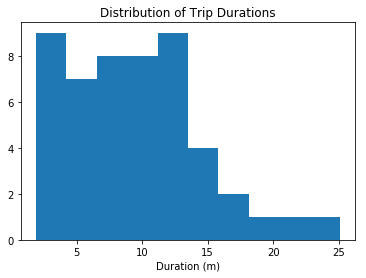

In [14]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. If you want to know more, see:
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In the above cell, we collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

You will now use these functions to create a histogram of the trip times for the city you selected in question 4c. Don't separate the Subscribers and Customers for now: just collect all of the trip times and plot them.

In [15]:
## Use this and additional cells to collect all of the trip times as a list ##
## and then use pyplot functions to generate a histogram of trip times.     ##

with open('./data/NYC-2016-Summary.csv', 'r') as f_in:

    reader = csv.DictReader(f_in)
    duration_list = []
    
    for row in reader:
        duration_list.append(float(row['duration']))


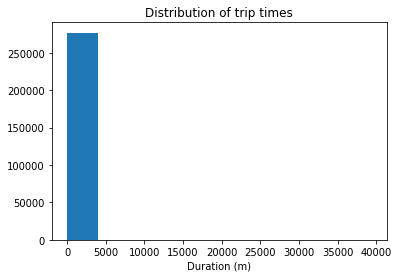

In [16]:
plt.hist(duration_list)
plt.title('Distribution of trip times')
plt.xlabel('Duration (m)')
plt.show()

If you followed the use of the `.hist()` and `.show()` functions exactly like in the example, you're probably looking at a plot that's completely unexpected. The plot consists of one extremely tall bar on the left, maybe a very short second bar, and a whole lot of empty space in the center and right. Take a look at the duration values on the x-axis. This suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, you will use additional parameters with the `.hist()` function to limit the range of data that is plotted. Documentation for the function can be found [[here]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

**Question 5**: Use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in your selected city. Do the same thing for only the Customers. Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, set the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?

**Answer**: 

> ***For each group, where is the peak of each distribution?***
> <br>*Distribution of trip times for the Subscribers in NYC: peak is at 0 - 15 min*
> <br>*Distribution of trip times for the Customers in NYC: peak is at 15 - 30 min*
> <br>***How would you describe the shape of each distribution?***
> <br>*Distribution shape for the Subscribers in NYC: positively skewed*
> <br>*Distribution shape for the Customers in NYC: positively skewed*

In [17]:
## Use this and additional cells to answer Question 5. ##

with open('./data/NYC-2016-Summary.csv', 'r') as f_in:

    reader = csv.DictReader(f_in)
    duration_list_subscribers = []
    duration_list_customers = []
        
    for row in reader:
        if row['user_type'] == 'Subscriber':
            duration_list_subscribers.append(float(row['duration']))
        else:
            duration_list_customers.append(float(row['duration']))

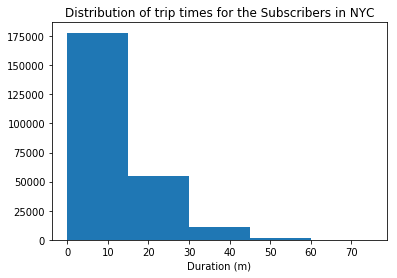

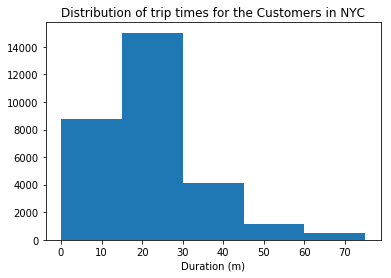

In [18]:
plt.hist(duration_list_subscribers, bins=5, range=(0, 75))
plt.title('Distribution of trip times for the Subscribers in NYC')
plt.xlabel('Duration (m)')
plt.show()

plt.hist(duration_list_customers, bins=5, range=(0, 75))
plt.title('Distribution of trip times for the Customers in NYC')
plt.xlabel('Duration (m)')
plt.show()

<a id='eda_continued'></a>
## Performing Your Own Analysis

So far, you've performed an initial exploration into the data available. You have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, you have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now it is your turn to continue the exploration in a direction that you choose. Here are a few suggestions for questions to explore:

- How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
- Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?
- During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?

If any of the questions you posed in your answer to question 1 align with the bullet points above, this is a good opportunity to investigate one of them. As part of your investigation, you will need to create a visualization. If you want to create something other than a histogram, then you might want to consult the [Pyplot documentation](https://matplotlib.org/devdocs/api/pyplot_summary.html). In particular, if you are plotting values across a categorical variable (e.g. city, user type), a bar chart will be useful. The [documentation page for `.bar()`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.bar.html#matplotlib.pyplot.bar) includes links at the bottom of the page with examples for you to build off of for your own use.

**Question 6**: Continue the investigation by exploring another question that could be answered by the data available. Document the question you want to explore below. Your investigation should involve at least two variables and should compare at least two groups. You should also use at least one visualization as part of your explorations.

**Answer**: 

> ***On what days are Subscribers most likely to use the system? What about Customers?***
> <br>*New York: Subscribers have 50580 rides on Weekends (20.6%) vs. 195316 rides on Weekdays (5.7%). Customers have 14125 rides on Weekends (45.7%) vs. 16777 rides on Weekdays (54.3%).*
> <br>*Chicago: Subscribers have 11048 rides on Weekends (20.1%) vs. 43934 rides on Weekdays (15.5%). Customers have 8533 rides on Weekends (49.8%) vs. 8616 rides on Weekdays (50.2%).*
> <br>*Washington: Subscribers have 10841 rides on Weekends (20.9%) vs. 40912 rides on Weekdays (12.1%). Customers have 6286 rides on Weekends (43.1%) vs. 8287 rides on Weekdays (56.9%).*
> <br>***Does the average duration of rides change depending on the day of the week?***
> <br>*After plotting the calculations we can see that the average duration of rides increases on Weekends.*

In [19]:
## Use this and additional cells to continue to explore the dataset. ##
## Once you have performed your exploration, document your findings  ##
## in the Markdown cell above.                                       ##

def what_days(filename):

    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize variables
        duration_list_subscribers_weekends = []
        duration_list_customers_weekends = []
        
        duration_list_subscribers_weekdays = []
        duration_list_customers_weekdays = []
        
        for row in reader:
            if row['user_type'] == 'Subscriber' and row['day_of_week'] in ['Sunday', 'Saturday']:
                duration_list_subscribers_weekends.append(float(row['duration']))
            elif row['user_type'] == 'Subscriber':
                duration_list_subscribers_weekdays.append(float(row['duration']))
            elif row['user_type'] == 'Customer' and row['day_of_week'] in ['Sunday', 'Saturday']:
                duration_list_customers_weekends.append(float(row['duration']))
            else:
                duration_list_customers_weekdays.append(float(row['duration']))
        
        # calculate the number of trips in each list
        w, x, y, z = len(duration_list_subscribers_weekends), len(duration_list_subscribers_weekdays), len(duration_list_customers_weekends), len(duration_list_customers_weekdays)
        
        # calculate proportions
        prop_subs_weekends = "{:.1%}".format(w / (w + x))
        prop_subs_weekdays = "{:.1%}".format(y / (w + x))
        prop_cust_weekends = "{:.1%}".format(y / (y + z))
        prop_cust_weekdays = "{:.1%}".format(z / (y + z))

        return(w, x, y, z, prop_subs_weekends, prop_subs_weekdays, prop_cust_weekends, prop_cust_weekdays)

In [20]:
list_of_files = ['./data/NYC-2016-Summary.csv', './data/Chicago-2016-Summary.csv', './data/Washington-2016-Summary.csv']
city_names = ['New York', 'Chicago', 'Washington']

for data in list_of_files:
    # get the data from "what_days" function
    w, x, y, z, prop_subs_weekends, prop_subs_weekdays, prop_cust_weekends, prop_cust_weekdays = what_days(data)
    # print out the result
    print (city_names[list_of_files.index(data)] + ": Subscribers have {} rides on Weekends ({}) vs. {} rides on Weekdays ({}). Customers have {} rides on Weekends ({}) vs. {} rides on Weekdays ({}).".format(w, prop_subs_weekends, x, prop_subs_weekdays, y, prop_cust_weekends, z, prop_cust_weekdays))

New York: Subscribers have 50580 rides on Weekends (20.6%) vs. 195316 rides on Weekdays (5.7%). Customers have 14125 rides on Weekends (45.7%) vs. 16777 rides on Weekdays (54.3%).
Chicago: Subscribers have 11048 rides on Weekends (20.1%) vs. 43934 rides on Weekdays (15.5%). Customers have 8533 rides on Weekends (49.8%) vs. 8616 rides on Weekdays (50.2%).
Washington: Subscribers have 10841 rides on Weekends (20.9%) vs. 40912 rides on Weekdays (12.1%). Customers have 6286 rides on Weekends (43.1%) vs. 8287 rides on Weekdays (56.9%).


In [21]:
def weekdays(filename):

    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize variables
        mo = []
        tu = []
        we = []
        th = []
        fr = []
        sa = []
        su = []
        
        # save all the durations according to the day of the week
        for row in reader:
            if row['day_of_week'] == 'Monday':
                mo.append(float(row['duration']))
            elif row['day_of_week'] == 'Tuesday':
                tu.append(float(row['duration']))
            elif row['day_of_week'] == 'Wednesday':
                we.append(float(row['duration']))
            elif row['day_of_week'] == 'Thursday':
                th.append(float(row['duration']))    
            elif row['day_of_week'] == 'Friday':
                fr.append(float(row['duration']))
            elif row['day_of_week'] == 'Saturday':
                sa.append(float(row['duration']))
            else:
                su.append(float(row['duration']))

        average_list = []
        
        # calculate the averages and save them to the output list
        for l in [mo, tu, we, th, fr, sa, su]:
            average = "{0:.2f}".format(sum(l) / len(l))
            average_list.append(average)
                
        return(average_list)

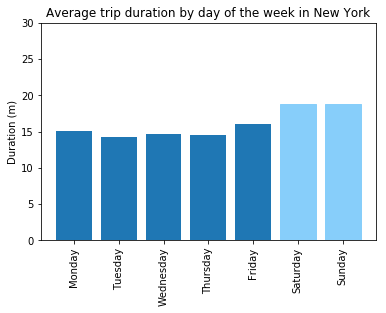

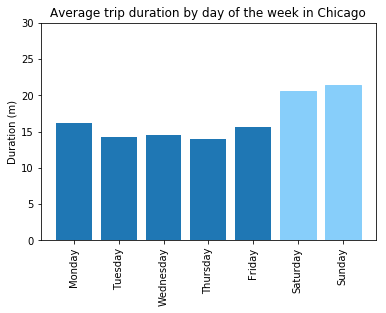

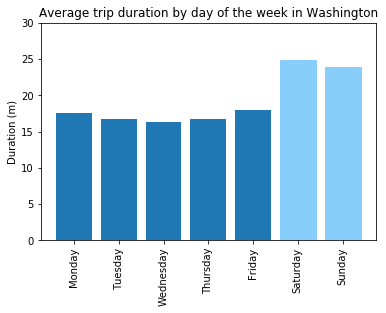

In [22]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for data in list_of_files:
    average_list = weekdays(data)
    
    # convert day names to indexes to sort them as in the initial list instead of alphabetically
    barchart = plt.bar(range(len(day_names)), list(map(float,average_list)))
    # avoid name overlapping by setting a vertical rotation for ticks
    plt.xticks(range(len(day_names)), day_names, rotation='vertical')
    
    # set different color for weekends
    barchart[5].set_color('lightskyblue')
    barchart[6].set_color('lightskyblue')
    
    plt.title('Average trip duration by day of the week in ' + city_names[list_of_files.index(data)])
    plt.ylabel('Duration (m)')
    
    plt.ylim(0, 30)
    plt.show()

In [23]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0